# Project: predicting orders for Glovo

Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.


## EDA

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?

### Loading

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import mlflow

In [26]:
data = pd.read_csv('../data/data_BCN.csv', parse_dates=[0], dayfirst=True)

### Visualizations

In [27]:
fig = px.line(data, x='time', y='orders', title='Hourly Glovo Orders (Zoomed in on 2020)')

fig.update_xaxes(range=['2022-01-01', '2022-02-01']) #inital window for better visualization

fig.show()

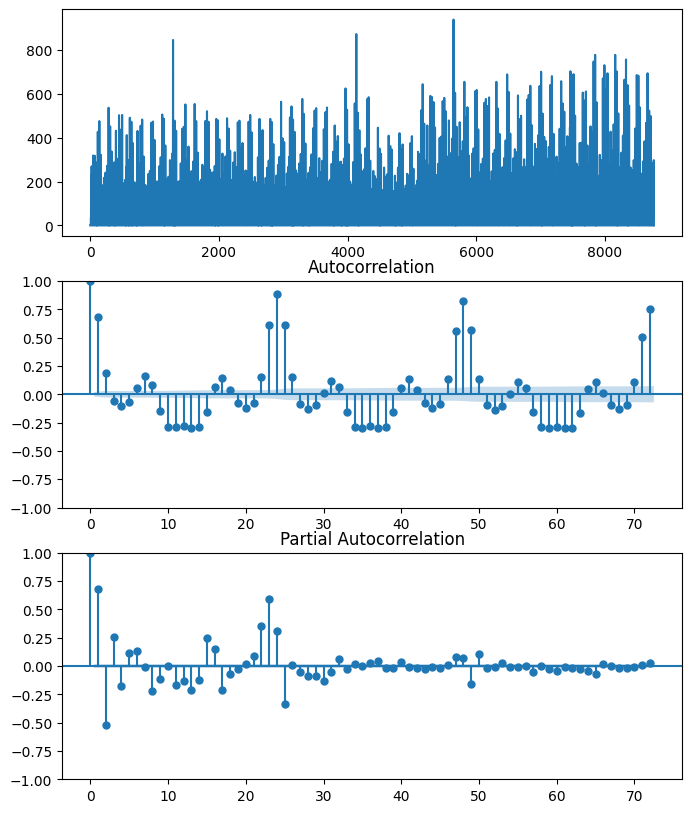

In [28]:
fig = plt.figure(figsize=(8,10))

ax1 = fig.add_subplot(311)
ax1.plot(data.orders)

ax2 = fig.add_subplot(312)
sm.graphics.tsa.plot_acf(data.orders, lags=72, ax=ax2); #semicolon, otherwise displays plots twice

ax3 = fig.add_subplot(313)
sm.graphics.tsa.plot_pacf(data.orders, lags=72, ax=ax3); 

plt.show()

## Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?

### With ARIMA Models

In [32]:
def log_ts(df:pd.DataFrame, ts_col:str) -> pd.DataFrame:
    # log
    df['log_'+ts_col] = np.log(df[ts_col] + 1)
    return df

In [33]:
data = log_ts(data, 'orders')

In [34]:
data

,time,orders,city,log_orders
0,2021-02-01 00:00:00,0.0,BCN,0.000000
1,2021-02-01 01:00:00,0.0,BCN,0.000000
2,2021-02-01 02:00:00,0.0,BCN,0.000000
3,2021-02-01 03:00:00,0.0,BCN,0.000000
4,2021-02-01 04:00:00,0.0,BCN,0.000000
...,...,...,...,...
8761,2022-02-01 19:00:00,101.0,BCN,4.624973
8762,2022-02-01 20:00:00,266.0,BCN,5.587249
8763,2022-02-01 21:00:00,298.0,BCN,5.700444
8764,2022-02-01 22:00:00,128.0,BCN,4.859812


In [35]:
from datetime import datetime

def to_datetime_obj(data:pd.DataFrame, col:str)->pd.DataFrame:

    data[col] = [datetime.strptime(time, '%Y-%m-%d %H:%M:%S') for time in data[col]]

    return data

In [36]:
data = to_datetime_obj(data, 'time')

In [37]:
data['time']

0      2021-02-01 00:00:00
1      2021-02-01 01:00:00
2      2021-02-01 02:00:00
3      2021-02-01 03:00:00
4      2021-02-01 04:00:00
               ...        
8761   2022-02-01 19:00:00
8762   2022-02-01 20:00:00
8763   2022-02-01 21:00:00
8764   2022-02-01 22:00:00
8765   2022-02-01 23:00:00
Name: time, Length: 8766, dtype: datetime64[ns]

In [38]:
data['1stdiff_log_orders'] = data['log_orders'].diff()

In [39]:
# mlflow.set_experiment('predicting_hourly_orders')

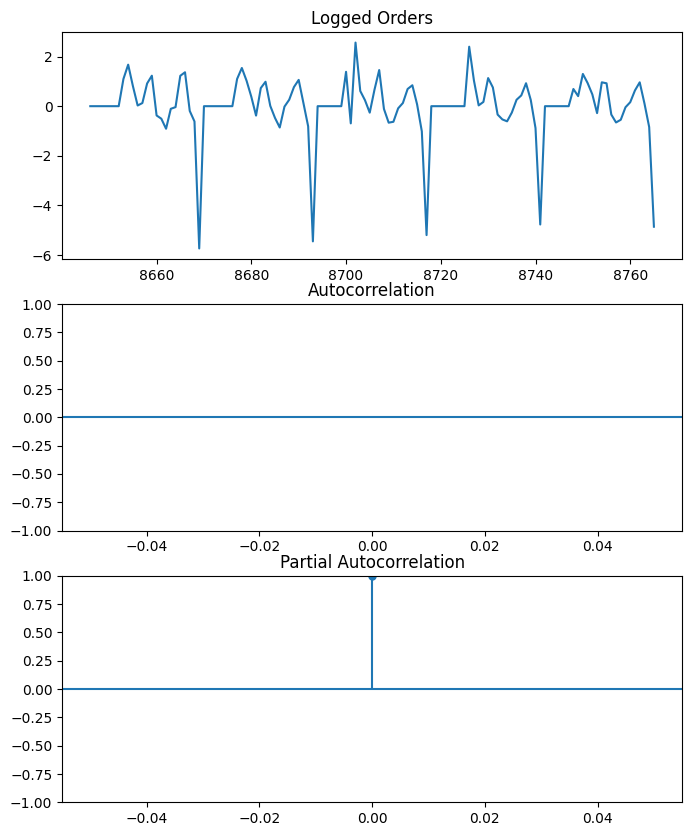

In [40]:
fig = plt.figure(figsize=(8,10))

ax1 = fig.add_subplot(311)
ax1.set_title('Logged Orders')
ax1.plot(data['1stdiff_log_orders'][-120:])

ax2 = fig.add_subplot(312)
sm.graphics.tsa.plot_acf(data['1stdiff_log_orders'], lags=120, ax=ax2)
ax3 = fig.add_subplot(313)
sm.graphics.tsa.plot_pacf(data['1stdiff_log_orders'], lags=120, ax=ax3)

plt.show()

In [14]:
train_time = ('2021-02-01 01:00:00', '2022-01-25 00:00:00')
test_time = ('2022-01-25 00:00:00', '2022-02-01 00:00:00')

modelling_data = data[(data['time'] >= train_time[0]) & (data['time'] < test_time[1])].copy()

# Filter data for training and testing periods
tr = modelling_data[(modelling_data['time'] >= train_time[0]) & (modelling_data['time'] < train_time[1])].set_index('time')
te = modelling_data[(modelling_data['time'] >= test_time[0]) & (modelling_data['time'] < test_time[1])].set_index('time')

# Create a new date range with hourly frequency
tr_hourly_index = pd.date_range(start=train_time[0], end='2022-01-24 23:00:00', freq='h')
te_hourly_index = pd.date_range(start=test_time[0], end='2022-01-31 23:00:00', freq='h')

# Reindex the dataframes
tr = tr.reindex(tr_hourly_index)
te = te.reindex(te_hourly_index)

In [15]:
# tr['weekday'] = tr['weekday'].apply(lambda x: 1 if x in ['Friday', 'Saturday', 'Sunday'] else 0)

# te['weekday'] = te['weekday'].apply(lambda x: 1 if x in ['Friday', 'Saturday', 'Sunday'] else 0)

In [16]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the train values trace
fig.add_trace(go.Scatter(
    x=tr.index[-240:], 
    y=tr['1stdiff_log_orders'].iloc[-240:], 
    mode='lines',
    name='train values'
))

# Add the test values trace
fig.add_trace(go.Scatter(
    x=te.index, 
    y=te['1stdiff_log_orders'], 
    mode='lines',
    name='test values'
))

# Update the layout
fig.update_layout(
    title='Train and Test Values',
    xaxis_title='Time',
    yaxis_title='1st Diff Log Orders',
    legend_title='Legend',
    width=1200,
    height=400
)

# Show the figure
fig.show()


In [17]:
# mlflow.set_experiment('predicting_hourly_consumption')

In [18]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

y = tr['1stdiff_log_orders']

forecaster = ARIMA(  
    order=(24, 0, 24),
    seasonal_order=(0, 0, 0, 0),
    suppress_warnings=True)

forecaster.fit(y=y)

y_pred = forecaster.predict(fh=range(1, (len(te)+1)))  

In [19]:
y_pred

2022-01-25 00:00:00   -0.140317
2022-01-25 01:00:00    0.002728
2022-01-25 02:00:00   -0.117562
2022-01-25 03:00:00    0.021829
2022-01-25 04:00:00    0.183525
                         ...   
2022-01-31 19:00:00    0.363075
2022-01-31 20:00:00    0.695896
2022-01-31 21:00:00    0.070905
2022-01-31 22:00:00   -0.930931
2022-01-31 23:00:00   -3.361332
Freq: h, Name: 1stdiff_log_orders, Length: 168, dtype: float64

In [20]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the train values trace
fig.add_trace(go.Scatter(
    x=tr.index[-120:], 
    y=tr['1stdiff_log_orders'].iloc[-120:], 
    mode='lines',
    name='train values'
))

# Add the test values trace
fig.add_trace(go.Scatter(
    x=te.index, 
    y=te['1stdiff_log_orders'], 
    mode='lines',
    name='test values'
))

# Add the prediction values trace
fig.add_trace(go.Scatter(
    x=te.index,  # Assuming y_pred has the same index as te
    y=y_pred, 
    mode='lines',
    name='prediction'
))

# Update the layout
fig.update_layout(
    title='Train, Test, and Prediction Values',
    xaxis_title='Time',
    yaxis_title='1st Diff Log Orders',
    legend_title='Legend',
    width=1200,
    height=400
)

# Show the figure
fig.show()


In [21]:
from sklearn.metrics import mean_squared_error, r2_score

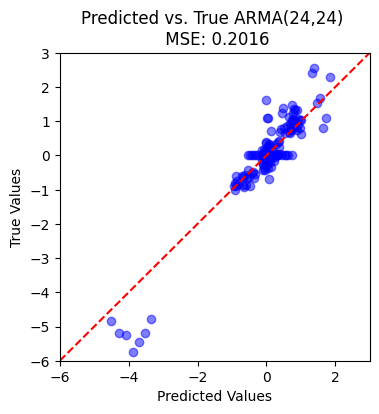

In [41]:
# Create a scatter plot

plt.figure(figsize=(4, 4))
plt.scatter(y_pred, te['1stdiff_log_orders'], color='blue', alpha=0.5)
plt.plot([-6, 3], [-6, 3], color='red', linestyle='--')  # Diagonal line representing perfect predictions

# # calculate root mean squared error
mse_sarima_te = mean_squared_error(y_pred, te['1stdiff_log_orders'])
r2_sarima_te = r2_score(y_pred, te['1stdiff_log_orders'])

# Add labels and title
plt.title('Predicted vs. True ARMA(24,24) \n MSE: %.4f' % (mse_sarima_te))

plt.xlabel('Predicted Values')
plt.ylabel('True Values')

# Set axis limits for better visualization
plt.xlim(-6, 3)
plt.ylim(-6, 3)
plt.show()

### SARIMAX

### With a NNet

In [22]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense

In [ ]:
te

,orders,city,log_orders,1stdiff_log_orders
2022-01-25 00:00:00,0.0,BCN,0.000000,0.000000
2022-01-25 01:00:00,0.0,BCN,0.000000,0.000000
2022-01-25 02:00:00,0.0,BCN,0.000000,0.000000
2022-01-25 03:00:00,0.0,BCN,0.000000,0.000000
2022-01-25 04:00:00,0.0,BCN,0.000000,0.000000
...,...,...,...,...
2022-01-31 19:00:00,87.0,BCN,4.477337,0.434286
2022-01-31 20:00:00,221.0,BCN,5.402677,0.925341
2022-01-31 21:00:00,284.0,BCN,5.652489,0.249812
2022-01-31 22:00:00,117.0,BCN,4.770685,-0.881805


In [ ]:
tr

,orders,city,log_orders,1stdiff_log_orders
2021-02-01 01:00:00,0.0,BCN,0.000000,0.000000
2021-02-01 02:00:00,0.0,BCN,0.000000,0.000000
2021-02-01 03:00:00,0.0,BCN,0.000000,0.000000
2021-02-01 04:00:00,0.0,BCN,0.000000,0.000000
2021-02-01 05:00:00,0.0,BCN,0.000000,0.000000
...,...,...,...,...
2022-01-24 19:00:00,75.0,BCN,4.330733,0.593064
2022-01-24 20:00:00,193.0,BCN,5.267858,0.937125
2022-01-24 21:00:00,218.0,BCN,5.389072,0.121214
2022-01-24 22:00:00,102.0,BCN,4.634729,-0.754343


In [ ]:
X_tr = tr['1stdiff_log_orders']

In [ ]:
tf.random.set_seed(7)

# Create and compile the LSTM network

model = Sequential()
model.add(Input(shape=(X_tr.shape[1], X_tr.shape[2])))  # Specify the input shape using Input layer
model.add(LSTM(6))
model.add(Dense(1))

model.compile(loss='mean_squared_error', 
              optimizer='adam')

#early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Fit the model using the training data
history = model.fit(X_tr, 
                    y_tr,
                    epochs=60, 
                    batch_size=1, 
                    verbose=2,
                    validation_split=0.2,)
                    #callbacks=[early_stopping])  # Assuming you have validation data X_val and y_val

# Plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:

# split into train and test sets
train_size = int(len(data_scaled) * 0.67)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:]
train = pd.DataFrame(train, columns=data.columns, index=data[:len(train)].index)
test = pd.DataFrame(test, columns=data.columns, index=data[len(train):].index)
y_tr = train['logret']
X_tr = train.drop(columns='logret')

y_te = test['logret']
X_te = test.drop(columns='logret')
X_tr
X_te = np.array(X_te).reshape((X_te.shape[0], 1, X_te.shape[1]))
X_tr = np.array(X_tr).reshape((X_tr.shape[0], 1, X_tr.shape[1]))
# fix random seed for reproducibility
tf.random.set_seed(7)
import matplotlib.pyplot as plt

# Create and compile the LSTM network
model = Sequential()
model.add(Input(shape=(X_tr.shape[1], X_tr.shape[2])))  # Specify the input shape using Input layer
model.add(LSTM(6))
model.add(Dense(1))

model.compile(loss='mean_squared_error', 
              optimizer='adam')

#early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Fit the model using the training data
history = model.fit(X_tr, 
                    y_tr,
                    epochs=60, 
                    batch_size=1, 
                    verbose=2,
                    validation_split=0.2,)
                    #callbacks=[early_stopping])  # Assuming you have validation data X_val and y_val

# Plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions using the test data
trainPredict = model.predict(X_te)

# make predictions
trainPredict = model.predict(X_tr)
testPredict = model.predict(X_te)

scaler2 = MinMaxScaler()

scaler2.min_, scaler2.scale_ = scaler.min_[0], scaler.scale_[0]

trainPredict = scaler2.inverse_transform(trainPredict)
trainY = scaler2.inverse_transform([y_tr])
testPredict = scaler2.inverse_transform(testPredict)
testY = scaler2.inverse_transform([y_te])

# # calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

trainPredict = pd.Series(trainPredict.ravel(), index=train.index)
testPredict = pd.Series(testPredict.ravel(), index=test.index)


plt.figure(figsize=(12, 6))  # Adjust width and height as needed

# Plot baseline and predictions
plt.plot(data['logret'], label='SP500 Log Returns', linewidth=1, color='darkblue')
plt.plot(trainPredict, label='Train Predictions', linewidth=0.9, color='green')
plt.plot(testPredict, label='Test Predictions', linewidth=1, color='red')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('SP500 Prediction with LSTM')
plt.legend()

# Show plot
plt.show()


In [68]:
array_of_values = data['log_orders']
array_of_dates = data['time']
fcst_horizon_length = 1

In [69]:
from scalecast.Forecaster import Forecaster

f = Forecaster(
    y = array_of_values,
    current_dates = array_of_dates,
    future_dates=fcst_horizon_length,
    test_length = 0.2, # do you want to test all models? if so, on how many or what percent of observations?
    cis = False, # evaluate conformal confidence intervals for all models?
    metrics = ['mae'], # what metrics to evaluate over the validation/test sets?
)

In [70]:
f.set_estimator('lstm')

In [85]:
f.manual_forecast(
    lags= 2400,
    batch_size=64,
    epochs=4,
    validation_split=.2,
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.0001,
    lstm_layer_sizes=(64,)*4,
    dropout=(0,)*4,
)

Epoch 1/4
 4/36 ━━━━━━━━━━━━━━━━━━━━ 1:42 3s/step - loss: 0.3923

KeyboardInterrupt: 

(19024.0, 19026.0)

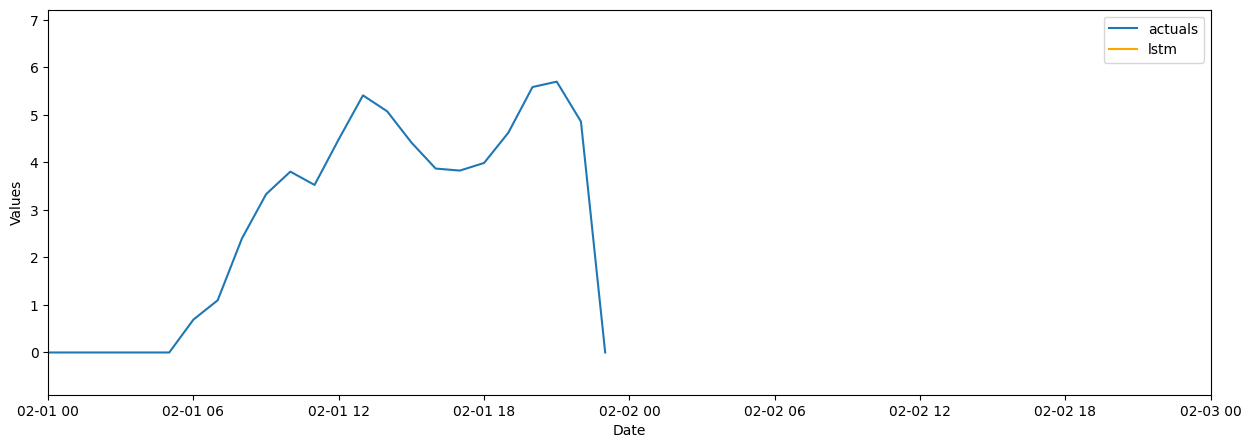

In [84]:
f.plot(models='lstm', figsize=(15,5))
plt.xlim(xmin=pd.to_datetime('2022-02-01'), xmax=pd.to_datetime('2022-02-03'))